# TikTok data and LLM coding

### Setup 

Run the following cells to set up this notebook

In [68]:
import ast
from IPython.display import display, clear_output
import json
from ipywidgets import widgets, VBox, HBox, Button, Label, Output
import krippendorff
import pandas as pd
import pyktok as pyk
import random
from openai import OpenAI
import seaborn as sns
import matplotlib.pyplot as plt

from dotenv import load_dotenv

_ = load_dotenv()

In [69]:
client = OpenAI()

In [70]:
import nest_asyncio
nest_asyncio.apply()

## Exploring Public Opinion in TikTok Comments

This week we will be exploring TikTok's role in shaping public opinion. Social media has become a popular site of discourse, and platforms like TikTok have been credited for shaping popular culture, politics, and everyday interactions. TikTok comment sections are a site where public opinion is debated and negotiated. At the same time, platform-level decisions alter what comments are most visible on comment pages.

## Choosing a Debate

Create a group of 2 (where at least one person in the group has a TikTok account) and find a video related to popular culture that has discusses two clearly defined positions as a part of a greater debate. This video should also have at least 1k comments. Copy the url of the video and paste it below.

In [71]:
# Replace with your video URL
video_url = "https://www.tiktok.com/@abcnews/video/7413187084074159391"

## Scrape Comments!

## Define a Research Question
What are you hoping to learn by studying comments on this video?

Drafts: What is the variation of the arguments presented by both sides? What argument do most people in the comment section vocalize?

Final question: To what extent do commenters use humor to criticize consumerist behavior?

## Defining Concepts
Quantitative content analysis is a popular method for translating non-numeric content into numeric, quantitative data. To do so, researchers create clearly defined and validated concepts. The first step in studying our TikTok debate is clearly defining how each position should be coded.

In [72]:
concept1 = "Code 1 if the comment incorporates humor--use of laughing emojis, indirect humorous commentary, comparisons, sarcasm or irony, jokes, etc. Code 0 if the comment does not include humor or any of these elements."
concept2 = "Code 1 if the comment directly criticizes consumerist behavior (e.g. agrees with the video, finds the situation embarassing, the commenter does not identify with the behavior, etc). Code 0 if the comment does not criticize consumerist behavior."

#concept1 = "Code 1 if the comment agrees with the video--waiting for the starbucks bear cup is embarrassing. Code 0 if the comment doesn't agree with the video."
#concept2 = "Code 1 if the comment disagrees with the video--individual choice should be respected or whether they wait doesn't matter. Code 0 if the comment doesn't disagree with the video."

In [73]:
df = pd.read_csv('@chloegillette_video_7570029600726682935_comments.csv') 

## Let's Code!

In [74]:
# !!Replace with your filename!!
df = pd.read_csv('@chloegillette_video_7570029600726682935_comments.csv') 

sample_df = df.sample(n=100, random_state=42).reset_index(drop=True)
text_col = 'text'

for col in ['coder1_concept1', 'coder1_concept2', 'coder2_concept1', 'coder2_concept2']:
    sample_df[col] = None

main_out = Output()
coder1_out = Output()
coder2_out = Output()

def code_entries(coder_label, concept1_col, concept2_col, container_out, next_callback=None):
    index = 0
    text_label = Label(value=sample_df.loc[index, text_col])

    # !!Change the descriptions to your concepts!!
    concept1 = widgets.ToggleButtons(options=[0, 1], description='Concept 1:')
    concept2 = widgets.ToggleButtons(options=[0, 1], description='Concept 2:')
    
    next_button = Button(description='Next →', button_style='success')
    progress = Label(value=f"{coder_label}: {index + 1}/{len(sample_df)}")

    def next_entry(_):
        nonlocal index
        sample_df.loc[index, concept1_col] = concept1.value
        sample_df.loc[index, concept2_col] = concept2.value

        index += 1
        if index < len(sample_df):
            text_label.value = sample_df.loc[index, text_col]
            concept1.value = None
            concept2.value = None
            progress.value = f"{coder_label}: {index + 1}/{len(sample_df)}"
        else:
            container_out.clear_output()
            with container_out:
                display(Label(value=f"{coder_label} has finished coding! ✅"))
                if next_callback:
                    next_callback()
                else:
                    with main_out:
                        print("✅ Both coders finished. Saving data...")
                        sample_df.to_csv('coded_data.csv', index=False)
                        print("💾 Coded data saved to coded_data.csv")

    next_button.on_click(next_entry)

    with container_out:
        container_out.clear_output()
        display(VBox([progress, text_label, concept1, concept2, next_button]))

# ---- Workflow ----

def start_coder2():
    print("\n=== Coder 2: Please start coding ===")
    code_entries("Coder 2", "coder2_concept1", "coder2_concept2", coder2_out)

print(f"Concept 1: {concept1}")
print(f"Concept 2: {concept2}\n")

print("=== Coder 1: Please start coding ===")
code_entries("Coder 1", "coder1_concept1", "coder1_concept2", coder1_out, next_callback=start_coder2)

display(coder1_out, coder2_out, main_out)


Concept 1: Code 1 if the comment incorporates humor--use of laughing emojis, indirect humorous commentary, comparisons, sarcasm or irony, jokes, etc. Code 0 if the comment does not include humor or any of these elements.
Concept 2: Code 1 if the comment directly criticizes consumerist behavior (e.g. agrees with the video, finds the situation embarassing, the commenter does not identify with the behavior, etc). Code 0 if the comment does not criticize consumerist behavior.

=== Coder 1: Please start coding ===


Output()

Output()

Output()

concept1 = "Code 1 if the comment incorporates humor--use of laughing emojis, indirect humorous commentary, comparisons, sarcasm or irony, jokes, etc. Code 0 if the comment does not include humor or any of these elements."

concept2 = "Code 1 if the comment directly criticizes consumerist behavior (e.g. agrees with the video, finds the situation embarassing, the commenter does not identify with the behavior, etc). Code 0 if the comment does not criticize consumerist behavior."


## Assess Interrater Reliability

In [81]:
df = pd.read_csv("coded_data.csv")

def krippendorff_alpha_for_concept(df, concept_name):
    data = [
        df[f'coder1_{concept_name}'].tolist(),
        df[f'coder2_{concept_name}'].tolist()
    ]
    return krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')

alpha_concept1 = krippendorff_alpha_for_concept(df, "concept1")
alpha_concept2 = krippendorff_alpha_for_concept(df, "concept2")

print("Krippendorff’s Alpha Scores:")
print(f"• Concept 1: {alpha_concept1:.3f}")
print(f"• Concept 2: {alpha_concept2:.3f}")

Krippendorff’s Alpha Scores:
• Concept 1: 0.585
• Concept 2: 0.537


## Evaluate the interrater reliability and iterate!

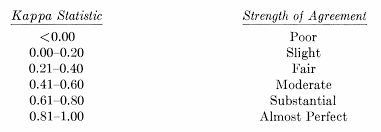

Describe your interrater reliability. If you scored high, great! How did your concept descriptions help you code effectively? If you scored poorly, what might you have done better?

**Regardless of your score, discuss potential edge cases and improve your concept descriptions**

Edge cases can be comments that:
- are more subtle or indirect in agreeing with the video (e.g. laughing, sharing analogies to the situation which may be seen as humorous, etc)
- the ones that both agreed and disagreed (e.g. Yes agree but you're also sad for caring so much.)

## Hire a LLM coder!
Write a prompt for an LLM to code the same 100 comments and calculate intercoder reliability. Be sure to tell the LLM their role!

In [90]:
LLM_prompt = '''You are a research assistant coding TikTok comments for a project examining how humor is used in criticisms of overconsumerism.
                You will be given individual comments responding to a TikTok video that mocks overconsumerism and, specifically, the eagerness of people trying to obtain the Starbucks bear cup.  
                Follow this codebook to code for concepts 1 and 2:
                - Code 1 if the comment incorporates humor--use of laughing emojis, indirect humorous commenta
                ry, comparisons, sarcasm or irony, jokes, etc. Code 0 if the comment does not include humor or any of these elements.
                - Code 1 if the comment directly criticizes consumerist behavior (e.g. agrees with the video, finds the situation embarassing, the commenter does not identify with the behavior, etc). Code 0 if the comment does not criticize consumerist behavior.

             ''' # give them clear instructions for how to code for concepts 1 & 2

## Code with your LLM coder!
For the human coding, agree on a code with your partner for each of the concept

In [102]:
text_col = "text"

sample_df = df.sample(n=100, random_state = 11).reset_index(drop = True)
sample_df["human_concept1"] = 'Code 1 if the comment incorporates humor--use of laughing emojis, indirect humorous commentary, sarcasm or irony, jokes, etc. Code 0 if the comment does not include humor or any of these elements.'
sample_df["human_concept2"] = 'Code 1 if the comment directly criticizes consumerist behavior (e.g. agrees with the video, finds the situation embarassing, the commenter does not identify with the behavior, etc). Code 0 if the comment does not criticize consumerist behavior.'

def code_entries():
    index = 0
    out = Output()

    text_label = widgets.Textarea(value=sample_df.loc[index, text_col], layout=widgets.Layout(width='600px', height='120px'))
    concept1 = widgets.ToggleButtons(options=[0, 1], description="Concept 1:")
    concept2 = widgets.ToggleButtons(options=[0, 1], description="Concept 2:")
    next_button = Button(description="Next →", button_style="success")
    progress = Label(value=f"Human Coding: {index + 1}/{len(sample_df)}")

    def next_entry(_):
        nonlocal index
        sample_df.loc[index, "human_concept1"] = concept1.value
        sample_df.loc[index, "human_concept2"] = concept2.value

        index += 1
        if index < len(sample_df):
            text_label.value = sample_df.loc[index, text_col]
            concept1.value = None
            concept2.value = None
            progress.value = f"Human Coding: {index + 1}/{len(sample_df)}"
        else:
            clear_output()
            display(Label(value="✅ Human coding complete! Now AI will code the same sample."))
            out.clear_output()

    next_button.on_click(next_entry)
    display(VBox([progress, text_label, concept1, concept2, next_button, out]))

code_entries()


In [103]:
sample_df.drop_duplicates(subset = 'cid').to_csv('human_coded_data2.csv')

In [104]:
sample_df.dropna(subset='author_pin').to_csv('human_coded_data.csv')
print("done human coding")

done human coding


In [94]:
import string

In [105]:
batch_size = 10

def ai_code_batch(text_list):
    texts_formatted = "\n".join([f"{i+1}. {t}" for i, t in enumerate(text_list)])
    
    prompt = f"""
        {LLM_prompt}
        
        You will receive {len(text_list)} texts.
        
        Return ONLY valid JSON — a list of {len(text_list)} dictionaries like this:
        
        [
          {{"concept1": 1, "concept2": 0}},
          ...
        ]
        
        No explanations, no comments, no extra text — only the JSON array.
        
        Texts:
        {texts_formatted}
        """

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )

    try:
        output_text = response.choices[0].message.content.strip()
        batch_json = json.loads(output_text)
        return batch_json  
    except Exception as e:
        try:
            print("Trying to parse")
            s = string.replace("```", "").replace("json", "").replace("\n", "").strip()
            lst = json.loads(s)
            print("✅ Parsed successfully.")
            return lst
        except Exception as e:
            print("⚠️ Parsing error:", e)

            return [{"concept1": None, "concept2": None} for _ in text_list]

In [106]:
sample_ai_concept1, sample_ai_concept2 = [], []

for start in range(0, len(sample_df), batch_size):
    print(f"Beginning coding round {batch_size/10}")
    end = start + batch_size
    sample_batch_texts = sample_df[text_col].iloc[start:end].tolist()
    sample_batch_results = ai_code_batch(sample_batch_texts)

    for r in sample_batch_results:
        sample_ai_concept1.append(r.get("concept1"))
        sample_ai_concept2.append(r.get("concept2"))

sample_df["ai_concept1"] = sample_ai_concept1
sample_df["ai_concept2"] = sample_ai_concept2

sample_df.to_csv("ai_coded_data.csv", index=False)
print("✅ Combined human + AI coded data saved to ai_coded_data.csv")


Beginning coding round 1.0
Beginning coding round 1.0
Beginning coding round 1.0
Trying to parse
⚠️ Parsing error: module 'string' has no attribute 'replace'
Beginning coding round 1.0
Beginning coding round 1.0
Beginning coding round 1.0
Beginning coding round 1.0
Beginning coding round 1.0
Beginning coding round 1.0
Beginning coding round 1.0
Beginning coding round 1.0
✅ Combined human + AI coded data saved to ai_coded_data.csv


## Evaluate your agreement
Repeat the process until you reach at least 0.7 agreeability with the LLM

In [108]:
def krippendorff_alpha_for_concept(df, concept_name):
    data = [
        df[f"human_{concept_name}"].tolist(),
        df[f"ai_{concept_name}"].tolist()
    ]
    return krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')

alpha_c1 = krippendorff_alpha_for_concept(sample_df, "concept1")
alpha_c2 = krippendorff_alpha_for_concept(sample_df, "concept2")

print("Krippendorff’s Alpha between Human and AI:")
print(f"• Concept 1: {alpha_c1:.3f}")
print(f"• Concept 2: {alpha_c2:.3f}")

ValueError: Don't know how to construct value domain for dtype kind O.

## Use your prompt to code the entire comments dataset

In [41]:
# !! Change file name !!
comments = pd.read_csv('@chloegillette_video_7570029600726682935_comments.csv')

ai_concept1, ai_concept2 = [], []

for start in range(0, len(comments), batch_size):
    print(f"Beginning coding round {(start/10) + 1}")
    end = start + batch_size
    batch_texts = comments[text_col].iloc[start:end].tolist()
    batch_results = ai_code_batch(batch_texts)

    for r in batch_results:
        ai_concept1.append(r.get("concept1"))
        ai_concept2.append(r.get("concept2"))

# Add results to dataframe
comments["ai_concept1"] = ai_concept1
comments["ai_concept2"] = ai_concept2

# Save to file
comments.to_csv("final_coded_data.csv", index=False)
print("✅ Finished Coding!")

Beginning coding round 1.0
Beginning coding round 2.0
Beginning coding round 3.0
Beginning coding round 4.0
Trying to parse
⚠️ Parsing error: name 'string' is not defined
Beginning coding round 5.0
Beginning coding round 6.0
Beginning coding round 7.0
Trying to parse
⚠️ Parsing error: name 'string' is not defined
Beginning coding round 8.0
Beginning coding round 9.0
Beginning coding round 10.0
Beginning coding round 11.0
Beginning coding round 12.0
Beginning coding round 13.0
Trying to parse
⚠️ Parsing error: name 'string' is not defined
Beginning coding round 14.0
Beginning coding round 15.0
Beginning coding round 16.0
Beginning coding round 17.0
Beginning coding round 18.0
Beginning coding round 19.0
Beginning coding round 20.0
Trying to parse
⚠️ Parsing error: name 'string' is not defined
Beginning coding round 21.0
Beginning coding round 22.0
Beginning coding round 23.0
Beginning coding round 24.0
Beginning coding round 25.0
Beginning coding round 26.0
Beginning coding round 27.0
B

## Analyze your data

In [ ]:
final_coded_data = pd.read_csv("final_coded_data.csv")

#### Exploring quantity of comments

In [ ]:
counts = {
    "ai_concept1": final_coded_data["ai_concept1"].sum(),
    "ai_concept2": final_coded_data["ai_concept2"].sum()
}

count_df = pd.DataFrame(list(counts.items()), columns=["Concept", "Total_1s"])

plt.figure(figsize=(6, 4))
plt.bar(count_df["Concept"], count_df["Total_1s"])
plt.title("Total Count of 1s by AI Concept")
plt.ylabel("Count of 1s")
plt.xlabel("Concept")
plt.tight_layout()
plt.show()

#### What comments received more likes?

In [ ]:
def collapse(x):
    if x.ai_concept1 == 1:
        return "concept1"
    elif x.ai_concept2 == 1:
        return "concept2"
    else:
        return "neither"

final_coded_data['collapsed_codes'] = final_coded_data.apply(collapse, axis=1)

In [ ]:
sns.barplot(data=final_coded_data, y='collapsed_codes', x='digg_count')

#### What comments got the most replies?

In [ ]:
sns.barplot(data=final_coded_data, y='collapsed_codes', x='reply_comment_total')

#### What types of comments are shown more?
This is a visibility metric: higher scores means higher visibility in the comment section

In [ ]:
final_coded_data['sort_extra_score_loaded'] = final_coded_data.sort_extra_score.apply(lambda x: ast.literal_eval(x))
final_coded_data['show_more'] = final_coded_data.sort_extra_score_loaded.apply(lambda x: float(dict(x)['show_more_score']))
sns.barplot(data=final_coded_data, y='collapsed_codes', x='show_more')

#### Are there differences in age between commenters?

In [ ]:
final_coded_data['users_loaded'] = final_coded_data.user.apply(lambda x: ast.literal_eval(x))
final_coded_data['age'] = final_coded_data.users_loaded.apply(
    lambda x: x['predicted_age_group'] if isinstance(x, dict) and 'predicted_age_group' in x else None
)

def reduce(x):
    try:
        return float(x)
    except:
        return float('nan')
final_coded_data['age'] = final_coded_data.age.apply(reduce)


In [ ]:
sns.barplot(data=final_coded_data.dropna(subset='age'), y='collapsed_codes', x='age')

- group -1 = 13-17
- group 1 = 18-24
- group 2 = 25-34
- group 3 = 35-44
- group 4 = 45-54
- group 5 = 55+

#### Use an LLM to create one more visualization or analysis
You might need to inspect your data!

## What does it all mean??
Spend 2-3 paragraphs reflecting on the results from your analysis. What are the implications of this work?